### ADALINE

**Implementation of ADALINE Using PyTorch**

The credits for the image go to Stats 453 course by Sebastian Raschka

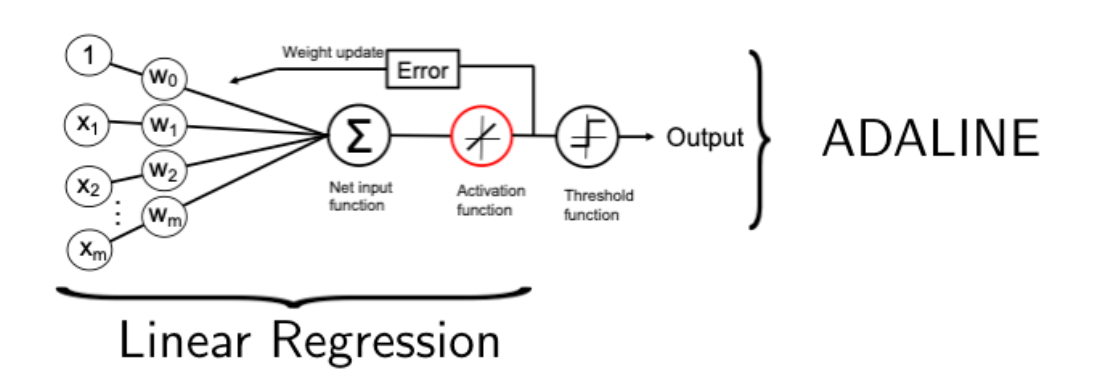



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn.functional as F

In [2]:
df = pd.read_csv('/content/iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)

In [3]:
df

,x1,x2,x3,x4,y
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


In [4]:
# Assign features and target

X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

In [5]:
torch.manual_seed(123)

shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)

X=X[shuffle_idx]
y=y[shuffle_idx]

In [6]:
percent70=int(X.shape[0]*0.7)

X_train=X[:percent70]
y_train=y[:percent70]

X_test=X[percent70:]
y_test=y[percent70:]

In [7]:
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

## 1. ADALINE Semi Automated

In [8]:
class ADALINE():
  """
    Implementation of ADALINE using minibatch gradient descent in PyTorch.
  """
  def __init__(self,num_features):
    self.num_features = num_features
    self.weights = torch.zeros(num_features,1, dtype=torch.float,requires_grad=True)
    self.bias = torch.zeros(1, dtype=torch.float,requires_grad=True)

  def forward(self,X):
    """
        This method computes the net input and reshapes the output from a 2D tensor to a 1D tensor.

    """
    return (torch.matmul(X,self.weights)+self.bias).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10):
    """
        Trains the model using minibatch gradient descent.

        Before each epoch, the dataset is shuffled to prevent cycles during training.
    """
    torch.manual_seed(123)
    loss=[]
    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=torch.mean((y[minibatch_idx]-y_pred)**2,axis=0)
        grad_w=grad(mse,self.weights,retain_graph=True)[0]  # We took the 0th index as torch.autograd.grad returns a tuple of tensors,right now the tuple contains only one element but if we took the gradient wrt multiple tensors then we would have multiple elements in the tuple.Also we did retain_graph=TRue bcoz we still have to compute the gradient wrt bias
        grad_b=grad(mse,self.bias)[0]
        self.weights=self.weights-(lr*grad_w)
        self.bias=self.bias-(lr*grad_b)

      with torch.no_grad():
        # While defining the weights and biases we had written requires_grad=True ,so whenever they would be used computation graph would be automatically created
        # We used torch.no_grad() here because we dont want to unnecessarily create computation graph
        preds=self.forward(X)
        curr_loss=torch.mean((y-preds)**2)
        print(f'Epoch: {epoch+1}, Loss: {curr_loss}')
        loss.append(curr_loss)
    return loss



In [9]:
adaline=ADALINE(num_features=X_train.size(1))

In [10]:
loss=adaline.train(X_test,y_test,100,lr=0.01)

Epoch: 1, Loss: 0.3917551636695862
Epoch: 2, Loss: 0.3558187782764435
Epoch: 3, Loss: 0.3245258331298828
Epoch: 4, Loss: 0.297424852848053
Epoch: 5, Loss: 0.2737695872783661
Epoch: 6, Loss: 0.2531880736351013
Epoch: 7, Loss: 0.23517990112304688
Epoch: 8, Loss: 0.2194976657629013
Epoch: 9, Loss: 0.20569470524787903
Epoch: 10, Loss: 0.19352887570858002
Epoch: 11, Loss: 0.18287888169288635
Epoch: 12, Loss: 0.1735573559999466
Epoch: 13, Loss: 0.16537335515022278
Epoch: 14, Loss: 0.15815719962120056
Epoch: 15, Loss: 0.15182188153266907
Epoch: 16, Loss: 0.14627699553966522
Epoch: 17, Loss: 0.1412816345691681
Epoch: 18, Loss: 0.136959969997406
Epoch: 19, Loss: 0.1331118792295456
Epoch: 20, Loss: 0.12968795001506805
Epoch: 21, Loss: 0.12669573724269867
Epoch: 22, Loss: 0.1240149661898613
Epoch: 23, Loss: 0.12166807055473328
Epoch: 24, Loss: 0.11959648877382278
Epoch: 25, Loss: 0.11775138229131699
Epoch: 26, Loss: 0.11612154543399811
Epoch: 27, Loss: 0.11467055976390839
Epoch: 28, Loss: 0.11342

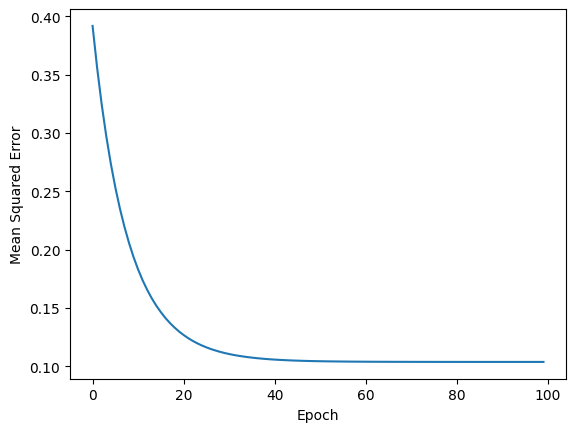

In [11]:
plt.plot(range(len(loss)), loss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [12]:
train_pred = adaline.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5,
                 1,
                 0) == y_train).float())


test_pred = adaline.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5,
                 1,
                 0) == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.86
Test Accuracy: 93.33


## 2. Linear Regression Automated

In [13]:
class ADALINE02(torch.nn.Module):
  """
    Implementation of ADALINE using minibatch gradient descent in PyTorch.
  """
  def __init__(self,num_features):
    super(ADALINE02, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)

    # changed random weights to zero to maintain uniformity with the previous implementation
    # (don't do this for multi-layer nets!)
    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()


  def forward(self,X):
    """
        This method computes the net input and reshapes the output from a 2D tensor to a 1D tensor.

    """
    return self.linear(X).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10):
    """
        Trains the model using minibatch gradient descent.

        Before each epoch, the dataset is shuffled to prevent cycles during training.
    """
    torch.manual_seed(120)
    loss=[]
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=F.mse_loss(y_pred, y[minibatch_idx])

        #### Reset gradients from previous iteration because otherwise pytorch will accumulate gradients
        optimizer.zero_grad()
        mse.backward()
        optimizer.step()

      with torch.no_grad():
        # While defining the weights and biases we had written requires_grad=True ,so whenever they would be used computation graph would be automatically created
        # We used torch.no_grad() here because we dont want to unnecessarily create computation graph
        preds=self.forward(X)
        curr_loss=torch.mean((y-preds)**2)
        print(f'Epoch: {epoch+1}, Loss: {curr_loss}')
        loss.append(curr_loss)
    return loss

In [14]:
adaline02=ADALINE02(num_features=X_train.size(1))
loss02=adaline02.train(X_test,y_test.float(),100,lr=0.01)

Epoch: 1, Loss: 0.39160266518592834
Epoch: 2, Loss: 0.3555474281311035
Epoch: 3, Loss: 0.3243701159954071
Epoch: 4, Loss: 0.2973920404911041
Epoch: 5, Loss: 0.2737596333026886
Epoch: 6, Loss: 0.253221720457077
Epoch: 7, Loss: 0.23518772423267365
Epoch: 8, Loss: 0.21947574615478516
Epoch: 9, Loss: 0.2056376039981842
Epoch: 10, Loss: 0.19355109333992004
Epoch: 11, Loss: 0.18297865986824036
Epoch: 12, Loss: 0.17366808652877808
Epoch: 13, Loss: 0.16546420753002167
Epoch: 14, Loss: 0.1582183539867401
Epoch: 15, Loss: 0.1518212854862213
Epoch: 16, Loss: 0.1462182104587555
Epoch: 17, Loss: 0.14126896858215332
Epoch: 18, Loss: 0.13692067563533783
Epoch: 19, Loss: 0.1330886036157608
Epoch: 20, Loss: 0.12968826293945312
Epoch: 21, Loss: 0.12670676410198212
Epoch: 22, Loss: 0.12405963987112045
Epoch: 23, Loss: 0.12169858813285828
Epoch: 24, Loss: 0.11960755288600922
Epoch: 25, Loss: 0.11777999252080917
Epoch: 26, Loss: 0.11612891405820847
Epoch: 27, Loss: 0.11469216644763947
Epoch: 28, Loss: 0.11

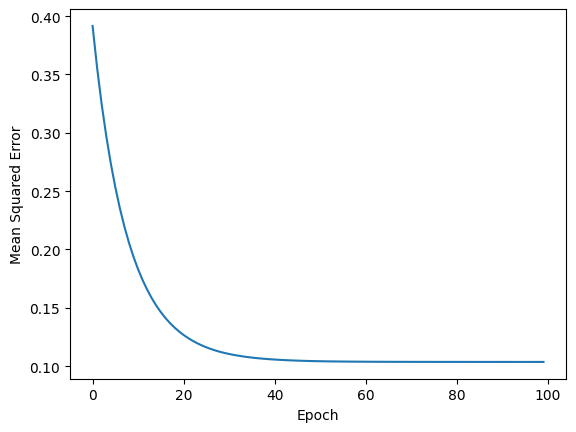

In [15]:
plt.plot(range(len(loss02)), loss02)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [16]:
train_pred = adaline02.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5,
                 1,
                 0) == y_train).float())


test_pred = adaline02.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5,
                 1,
                 0) == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.86
Test Accuracy: 93.33
